In [10]:
# %%
# 程式碼區塊 1：載入套件與資料

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 設定全局字體
plt.rcParams['font.family'] = 'Microsoft JhengHei'  # 設定字體為微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 顯示負號
# 讀取資料
df = pd.read_csv("VerbalFluencyTest_rawdata.csv")  # 請將檔案名稱改為你的檔名
df.head()


,受試者編號,年齡,性別,分析結果,詞彙流暢度,詞彙豐富度,說話速度,正確率,聲音流暢度
0,1,63,2,Normal,0.895205,0.684282,0.854517,1.000000,0.940569
1,2,67,2,Dementia,0.563597,0.267195,0.853779,0.653680,0.442837
2,3,69,1,Dementia,0.227932,0.136541,0.317103,0.317103,0.616538
3,4,58,2,Normal,1.000000,0.683591,0.939348,1.000000,0.895420
4,5,72,2,Dementia,0.606681,0.201904,0.407563,0.541407,0.436888


In [6]:
# %%
# 程式碼區塊 2：資料前處理（篩選與標準化）

# 移除 Inconclusive 樣本
df_model = df[df["分析結果"] != "Inconclusive"].copy()

df_model = df_model.dropna()

# 類別編碼：Normal → 0, Dementia → 1
label_encoder = LabelEncoder()
df_model["label"] = label_encoder.fit_transform(df_model["分析結果"])

# 特徵與目標欄位
features = ["詞彙流暢度", "詞彙豐富度", "說話速度", "正確率", "聲音流暢度", "年齡"]
X = df_model[features]
y = df_model["label"]

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
# %%
# 程式碼區塊 3：建立與訓練模型（Random Forest）

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 預測
y_pred = clf.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

    Dementia       0.90      0.93      0.91        28
      Normal       0.99      0.98      0.98       164

    accuracy                           0.97       192
   macro avg       0.94      0.96      0.95       192
weighted avg       0.97      0.97      0.97       192



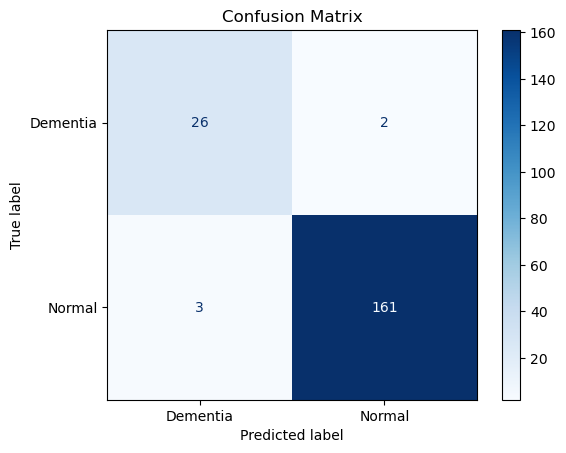

In [8]:
# %%
# 程式碼區塊 4：模型評估

# 類別名稱
class_names = label_encoder.classes_

# 評估報告
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 混淆矩陣
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


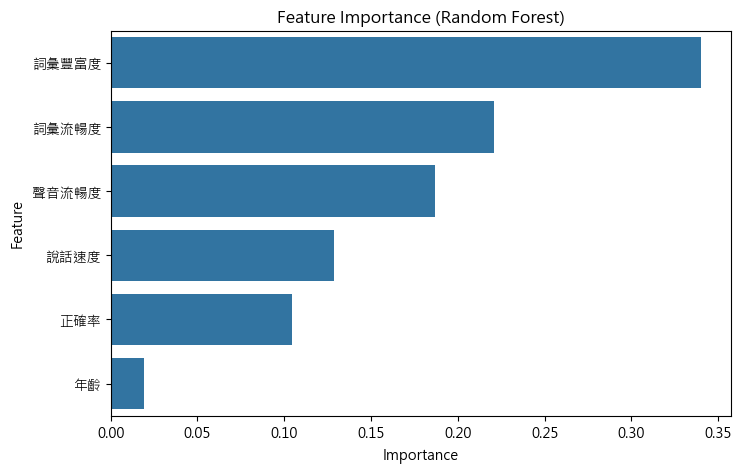

In [11]:
# %%
# 程式碼區塊 5：視覺化特徵重要性

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [features[i] for i in indices]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
# %%
# 程式碼區塊 6：Stratified k‑Fold 交叉驗證評估

from sklearn.model_selection import StratifiedKFold, cross_validate

# 我們用整筆資料 X_scaled, y 來做 CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = cross_validate(
    clf, X_scaled, y,
    cv=skf,
    scoring=scoring,
    return_train_score=False
)

# 輸出每個指標的平均與標準差
print("5‑Fold Cross‑Validation Results:")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"  • {metric:7s}: {scores.mean():.3f} ± {scores.std():.3f}")
